# Parameter fitting for GITT

This notebook is provides an example on how to combine pybamm-param's `GITT` and `OCPBalance` functionalities to estimate the electrode diffusion coefficient from real GITT data on a half-cell.

The workflow is as follows:
1. Load the data
2. Perform OCP Balance
3. Compute $\mathrm{d}U/\mathrm{d}x$
4. Perform GITT fit
5. Process the result

We start by importing the relevant packages

In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q # For Colab use
import pybamm
import pbparam
import pandas as pd
import numpy as np

## 1. Load the data
The first step is to load the data. In this case we have quite a lot of data to deal with: we need to load the GITT data, which is split into multiple files (one per pulse), and the reference OCP data vs stoichiometry that we will use for the OCP balance.

You may have a different workflow than below to load your data, but it is fine as long as the data is in the right format (i.e. GITT data split into pulses, with `"Time [s]"` and `"Positive electrode potential [V]"` columns).

In [2]:
import os
OCP_folder_path = os.path.join(pbparam.__path__[0], "input", "data")
pulse_folder_path = os.path.join(OCP_folder_path, "GITT")


# Load GITT data first
# Get a list of all files in the folder
all_files = os.listdir(pulse_folder_path)

# Filter the list to get only .csv files
csv_files = [file for file in all_files if file.endswith('.csv')]

# Extract pulse numbers from filenames and sort them
pulse_numbers = [int(file_name.split('_')[1].split('.csv')[0]) for file_name in csv_files]
sorted_files_by_pulse = [f"pulse_{num}.csv" for num in sorted(pulse_numbers)]

# Loop through each CSV file and read it into a DataFrame
# Store each DataFrame in a dictionary with the filename as the key
dfs = {}  

# Read all the pulses in the folder
for csv_file in sorted_files_by_pulse:
    file_path = os.path.join(pulse_folder_path, csv_file)
    dfs[csv_file] = pd.read_csv(file_path)

# Load OCP balance data next
cathode_half_lit = pd.read_csv(os.path.join(OCP_folder_path,"cathode_OCP_2_lit.csv")) # lithiation
cathode_half_delit = pd.read_csv(os.path.join(OCP_folder_path,"cathode_OCP_2_delit.csv")) # delithiation

For data interpretation reasons it is useful to have the charge in the data. Our dataset does not include it, but we can compute it integrating the current over time. 

In [3]:
## OPTIONAL ##
# If the charge is already calculated, it can be used instead of this.

# Calculation of Charge [A.h]
def compute_cumulative_charge(currents, times, starting_charge):
    q_values = [starting_charge]
    for i in range (1, len(currents)):
        dt = (times[i] - times[i-1]) / 3600
        dq = 0.5 * np.abs(currents[i]+currents[i-1]) * dt
        q_values.append(q_values[-1] + dq)
    return q_values

# Charges are calculated and added as a new column to the dataframe.
starting_charge = 0
for name, df in dfs.items():
    currents = df["Current [A]"].tolist()
    times = df["Time [s]"].tolist()
    q_values = compute_cumulative_charge(currents, times, starting_charge)
    starting_charge = q_values[-1]
    dfs[name]["Charge [A.h]"] = q_values

We can now display one of these dataframes to showcase its format.

In [4]:
# Individual pulses can be printed as below.
dfs["pulse_1.csv"]

,Time [s],Voltage [V],Current [A],Negative electrode potential [V],Positive electrode potential [V],Charge [A.h]
0,105749.3767,4.147639,0.000000e+00,0.090113,4.237751,0.000000e+00
1,105809.3769,4.147734,0.000000e+00,0.090017,4.237751,0.000000e+00
2,105869.3771,4.147772,0.000000e+00,0.089998,4.237771,0.000000e+00
3,105927.2243,4.147811,0.000000e+00,0.089998,4.237809,0.000000e+00
4,105927.2727,4.147582,-5.790000e-10,0.089998,4.237580,3.892167e-15
...,...,...,...,...,...,...
90,107185.0980,4.110606,0.000000e+00,0.092632,4.203238,2.875058e-04
91,107226.1511,4.111618,0.000000e+00,0.092193,4.203811,2.875058e-04
92,107286.1513,4.111560,0.000000e+00,0.092193,4.203754,2.875058e-04
93,107346.1515,4.111942,0.000000e+00,0.092041,4.203982,2.875058e-04


And we can also plot the positive electrode potential both as a function of time and charge.

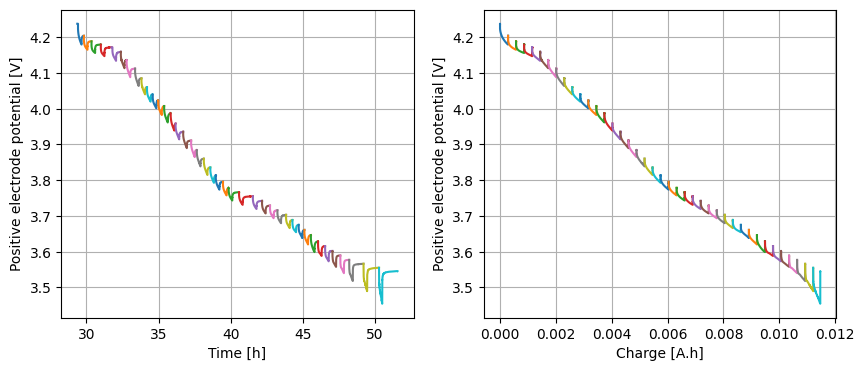

In [5]:
# Both of the Voltage vs Time and Charge can be plotted as below.
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for file_name, df in dfs.items():
    ax[0].plot(df['Time [s]'] / 3600, df["Positive electrode potential [V]"])
    ax[1].plot(df['Charge [A.h]'], df["Positive electrode potential [V]"])
ax[0].set_xlabel("Time [h]")
ax[1].set_xlabel("Charge [A.h]")
for a in ax:
    a.set_ylabel('Positive electrode potential [V]')
    a.grid(True)

## 2. Perform OCP Balance
Next, we need to perform an OCP balance to relate capacity to stoichiometry in our dataset. We extract the OCP curve from the pulses, by taking the first point of each dataset (this is just before the current is switched on).

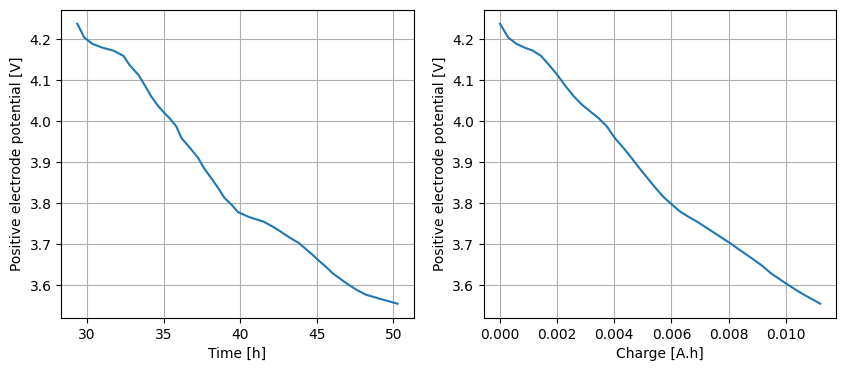

In [6]:
# saving the first values of each pulse.
first_values = [df['Positive electrode potential [V]'][0] for _, df in dfs.items()]
time_val = [df['Time [s]'][0] / 3600 for _, df in dfs.items()]
charge_val = [df['Charge [A.h]'][0] for _, df in dfs.items()]

# Plotting the first values.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(time_val,first_values)
ax[1].plot(charge_val,first_values)
ax[0].set_xlabel('Time [h]')
ax[1].set_xlabel('Charge [A.h]')
for a in ax:
    a.set_ylabel('Positive electrode potential [V]')
    a.grid(True)

We then assemble this data into a Pandas `DataFrame`.

In [7]:
pulse_values= pd.DataFrame(data={'Charge [A.h]': charge_val, 'Voltage [V]':first_values})

Finally we assemble the `OCPBalance` problem. Note that in this case we only have one OCP, so we fit it to both charge and discharge reference data to get a compromise solution. We also choose to use maximum likelihood estimation (MLE) as a cost function.

In [8]:
ocp_balance_cathode = pbparam.OCPBalance(
    [cathode_half_lit, cathode_half_delit],
    [pulse_values, pulse_values],
    
    cost_function=pbparam.MLE(),
)

Next we choose an optimiser and solve the optimisation problem, as usual.

In [9]:
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")
result_OCP = optimiser.optimise(ocp_balance_cathode)

We can visualise the results, and we notice that the OCP balance has been successful.

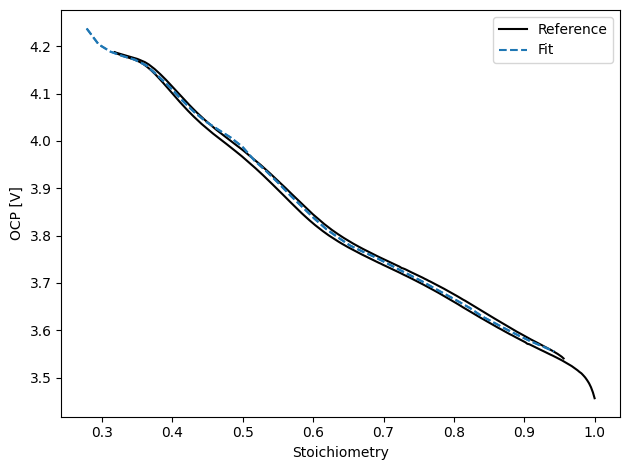


             Optimal values: {'Shift': -0.0046924494850563055, 'Stretch': 0.016877104212004102}
             Initial values: {'Shift': -0.46584169708029277, 'Stretch': 1.4658416970802928}
                  Optimiser: Maximum Likelihood Estimation
        Cost function value: -1646.5708939572546
                 Solve time: 862.908 ms
                    Message: Optimization terminated successfully.
        


In [10]:
result_OCP.plot()
print(result_OCP)

## 3. Compute $\mathrm{d}U/\mathrm{d}x$
We need to provide the derivative of the OCP with respect to stoichiometry (i.e. $\mathrm{d}U/\mathrm{d}x$) as an input for the GITT problem. To do so, we will compute the derivative with respect to capacity, and multiply by the `"Stretch"` parameter found in the OCP balance, which relates capacity to stoichiometry. To compute the derivative, we use finite differences, but note this might not be suitable if the OCP data is noisy (e.g. if pulses are very short).

In [11]:
dUdx = np.gradient(first_values,charge_val) * result_OCP.result_dict['Stretch']

And we can plot the values of the derivative as a function of the pulse number to check the results are reasonable.

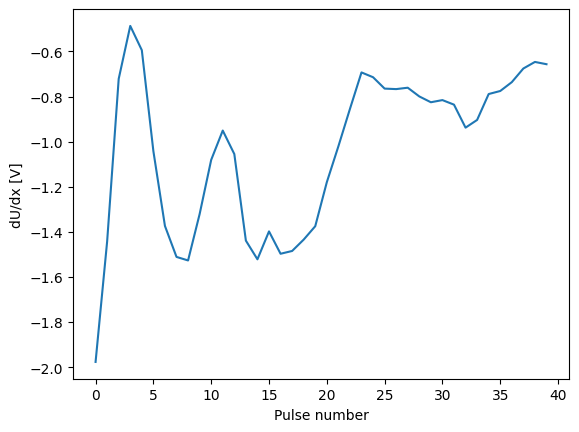

In [12]:
plt.plot(dUdx)
plt.xlabel("Pulse number");
plt.ylabel("dU/dx [V]");

## 4. Perform GITT fit
Now we have all the ingredients we need to perform the GITT fit. We first define a dictionary of the parameters required in the model (including the ones we will eventually fit). 

In [13]:
param_dict=pybamm.ParameterValues({
        "Reference OCP [V]": first_values[0],
        "Derivative of the OCP wrt stoichiometry [V]": dUdx[0],
        "Current function [A]": 1.15e-3,
        "Number of electrodes connected in parallel to make a cell": 1.0,
        "Electrode width [m]": np.pi * (1.8e-2) ** 2 / 4,   # effective area for a coin cell with 18 mm diameter
        "Electrode height [m]": 1,
        "Positive electrode active material volume fraction": 0.665,
        "Positive particle radius [m]": 5.22e-6,
        "Positive electrode thickness [m]": 75.6e-6,
        "Positive particle diffusivity [m2.s-1]": 5e-14,
        "Maximum concentration in positive electrode [mol.m-3]": 63104,
        "Initial concentration in positive electrode [mol.m-3]": 1000,
        "Effective resistance [Ohm]": 0,
        'Negative electrode thickness [m]': 0.0001,
        'Separator thickness [m]': 0.0001,
        'Negative particle radius [m]': 1e-05,
    })

Note that the parameters above are a subset of those required in the DFN model. Then, we can iterate over the various datasets and perform the GITT fit. `GITT` is a class similar to `DataFit`, but specific for GITT. As such, we do not need to provide a full simulation, but just the model we need to use. In this case we use the `WeppnerHuggins` model, which assumes the electrode potential evolves as the square root of time. Note that there is some data processing in the loop to segment out the discharge part and reset the time.

In [14]:
results = []
diffusions = []

optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

for (name, df), dUdx_i in zip(dfs.items(), dUdx):
    # We are doing this for positive electrode potential 
    # but it needs to be converted to 'Voltage [V]'
    pulse_data = df.filter(items=['Time [s]', 'Positive electrode potential [V]'])
    pulse_data.rename(columns={'Positive electrode potential [V]': 'Voltage [V]'}, inplace=True)
    
    # pulse data is filtered to remove currents below the threshold.
    pulse_data = pulse_data[df["Current [A]"] <= -1e-3]

    # Time [s] should start from 0 for every pulse! (Otherwise it will NOT work!)
    pulse_data['Time [s]'] = pulse_data['Time [s]'] - pulse_data['Time [s]'].iloc[0]

    #Parameter dictionary updated for every pulse
    param_dict.update({
        "Reference OCP [V]": pulse_data['Voltage [V]'].iloc[0],
        "Derivative of the OCP wrt stoichiometry [V]": dUdx_i,
    })

    # Optimisation problem is defined here.
    opt = pbparam.GITT(
        param_dict=param_dict,
        gitt_model=pbparam.WeppnerHuggins(),
        data=pulse_data,
        cost_function=pbparam.RMSE()
    )

    # Optimisation is done in step and saved in result.
    result = optimiser.optimise(opt)

    # The diffusion coefficient is the first parameter in the result.
    diffusions.append(result.x[0])
    
    # Store the result
    results.append(result) 

## 5. Process the result
We can finally plot the results.

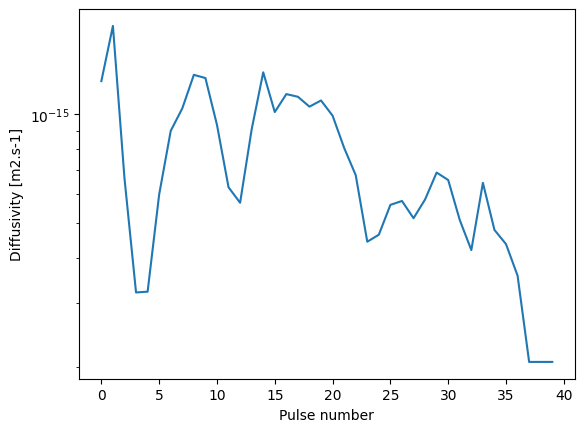

In [15]:
plt.semilogy(diffusions)
plt.xlabel("Pulse number");
plt.ylabel("Diffusivity [m2.s-1]");